In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import operator
import unicodedata
import string
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# EDA

In [186]:
df = pd.read_csv('sephora_review_db.csv.zip')

In [193]:
df.shape

(276072, 22)

Columns of interest based on the below columns include: brand, name, brand_id, product_id, rating, skin_type, eye_color, skin concerns, skin_tone, age, review_test, price, recommended, description

In [188]:
df.columns

Index(['brand', 'name', 'brand_id', 'brand_image_url', 'product_id',
       'product_image_url', 'rating', 'skin_type', 'eye_color',
       'skin_concerns', 'incentivized_review', 'skin_tone', 'age',
       'beauty_insider', 'user_name', 'review_text', 'price', 'recommended',
       'first_submission_date', 'last_submission_date', 'location',
       'description'],
      dtype='object')

Check to see how many missing values there are in the data

In [189]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [190]:
missing_zero_values_table(df)

Your selected dataframe has 22 columns and 276072 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_concerns,0,205155,74.3,205155,74.3,object
incentivized_review,75375,196593,71.2,271968,98.5,object
recommended,17083,194300,70.4,211383,76.6,object
beauty_insider,0,165061,59.8,165061,59.8,object
location,0,162276,58.8,162276,58.8,object
age,0,156495,56.7,156495,56.7,object
skin_type,0,141630,51.3,141630,51.3,object
eye_color,0,98497,35.7,98497,35.7,object
skin_tone,0,93144,33.7,93144,33.7,object
user_name,0,2943,1.1,2943,1.1,object


,brand_id,rating
count,276072.000000,276072.000000
mean,4720.242176,4.123881
std,1641.090961,1.255353
min,1070.000000,1.000000
25%,3976.000000,4.000000
50%,5648.000000,5.000000
75%,5879.000000,5.000000
max,7091.000000,5.000000


In [80]:
'''check what kind of values are in the description. Some ingredient names are featured in the 
marketing/description of the product '''

# df['description'].unique()

'check what kind of values are in the description. Some ingredient names are featured in the \nmarketing/description of the product '

In [177]:
# # number of reviwers who recommeded products by rating
# recom_groups = df.groupby(['rating', 'recommended']).count()['review_text']
# recom_groups

In [178]:
# recom_groups.plot(kind='bar', stacked=False)

It would be interesting to see what the average rating is by brand

In [181]:
# average brand ratings 
brand_ratings = df.groupby(['brand']).mean()['rating'].reset_index()
brand_ratings.sort_values('rating', inplace=True)
brand_ratings.head()

,brand,rating
13,DERMAdoctor,3.428571
1,Anastasia Beverly Hills,3.470391
33,LAWLESS,3.595238
42,Natasha Denona,3.613497
23,HUDA BEAUTY,3.674705


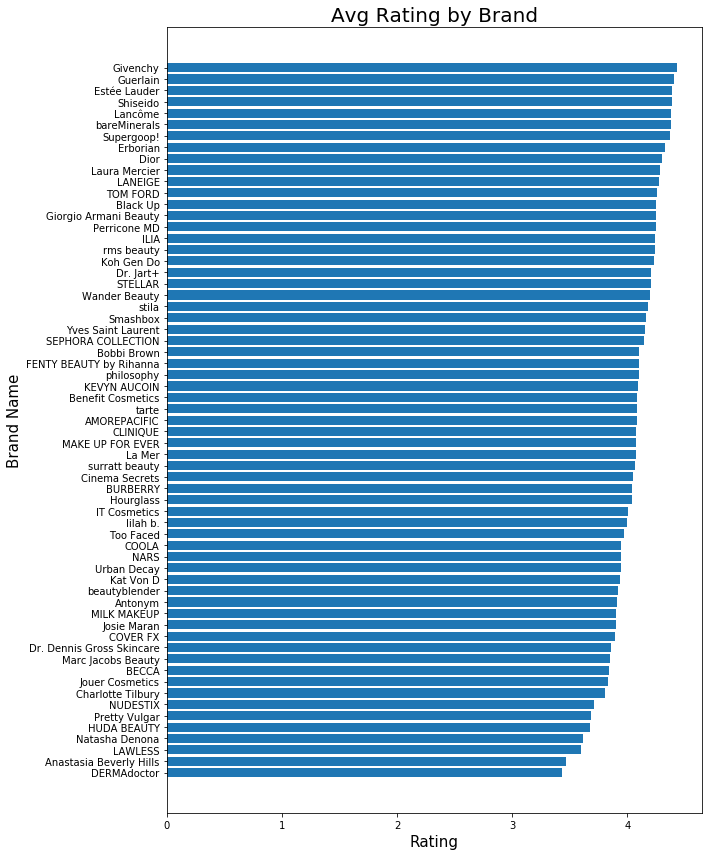

In [10]:
# plot brand and rating to see which brands have higher ratings
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(brand_ratings['brand'], brand_ratings['rating'])
plt.title('Avg Rating by Brand', fontsize=20)
ax.set_xlabel('Rating', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [11]:
# number of reviews by brand
num_of_reviews_brand = df.groupby('brand').nunique()['review_text'].reset_index()
num_of_reviews_brand.sort_values('review_text', inplace=True)
num_of_reviews_brand.head()

# brand_price = df.groupby(['brand']).mean()['price'].reset_index()
# brand_price.sort_values('price', inplace=True)
# brand_price.head()


,brand,review_text
44,Pretty Vulgar,19
15,Dr. Dennis Gross Skincare,35
12,Cinema Secrets,39
57,lilah b.,39
31,Koh Gen Do,39


Are the highest rated brands also the brands with the highest number of reviews? It looks like this isn't the case. BareMinerals has the high number of reviews, but has the 6th highest average rating for its products.

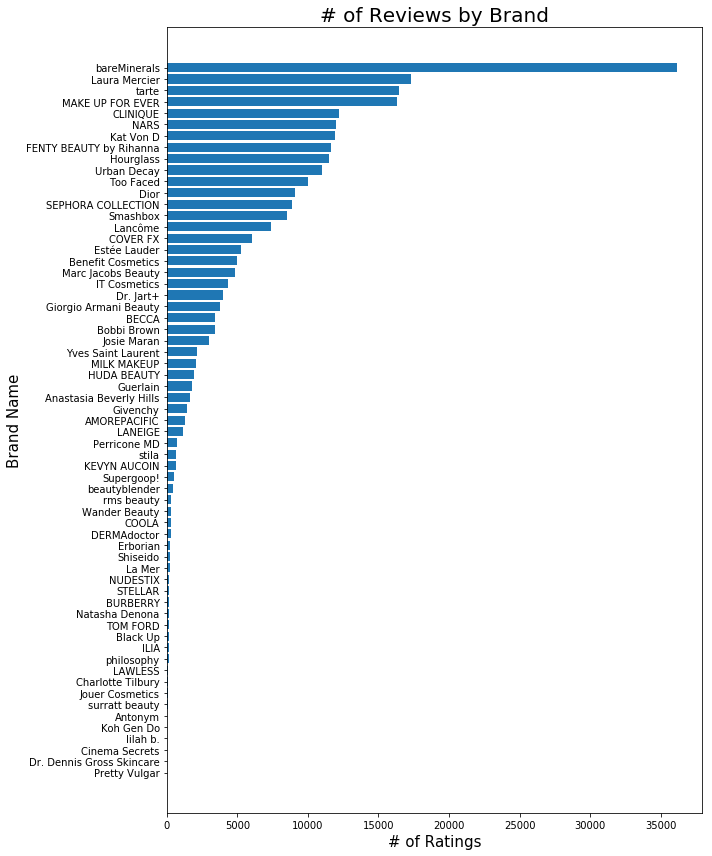

In [12]:
# plot brand and # of reviews to see most reviewed brands
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(num_of_reviews_brand['brand'], num_of_reviews_brand['review_text'])
plt.title('# of Reviews by Brand', fontsize=20)
ax.set_xlabel('# of Ratings', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [13]:
# count number of products per brand
num_prod = df.groupby('brand').nunique()['product_id'].reset_index()
num_prod.sort_values('product_id', inplace=True)
num_prod.head()

,brand,product_id
31,Koh Gen Do,1
23,HUDA BEAUTY,1
61,surratt beauty,1
33,LAWLESS,1
19,FENTY BEAUTY by Rihanna,1


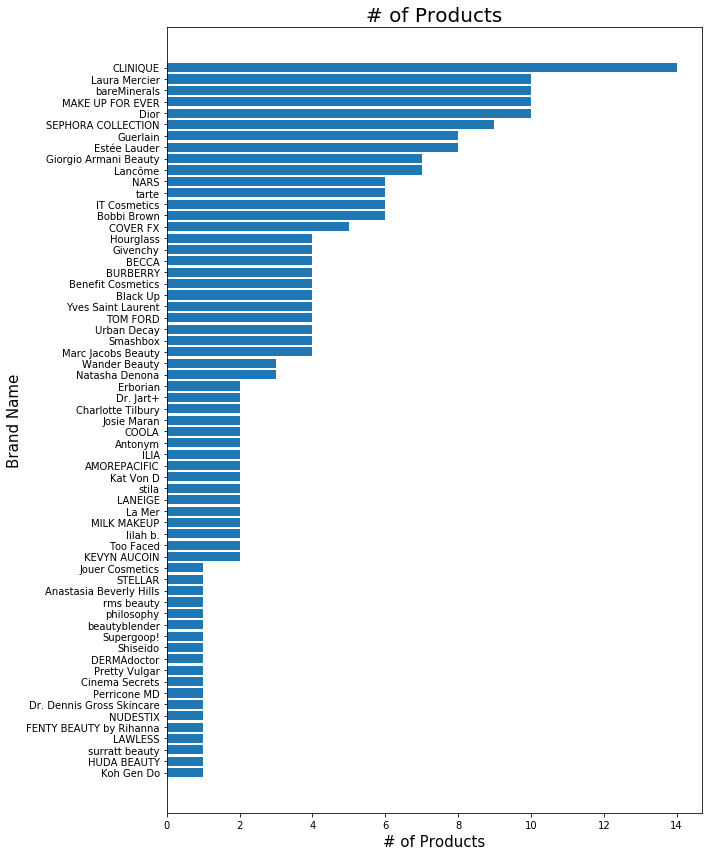

In [152]:
# plot brand and # of products per brand
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(num_prod['brand'], num_prod['product_id'])
plt.title('# of Products', fontsize=20)
ax.set_xlabel('# of Products', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [171]:
# create simple bar graphs by 1 group
def plot_skin(df, group, count_by):
    fig, ax = plt.subplots()
    skin_type_groups = df.groupby(group).count()[count_by]
    skin_type_groups.sort_values(ascending=False).plot(kind='bar', figsize=(10,7), cmap='Blues_r')
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='both', labelsize=10)
    

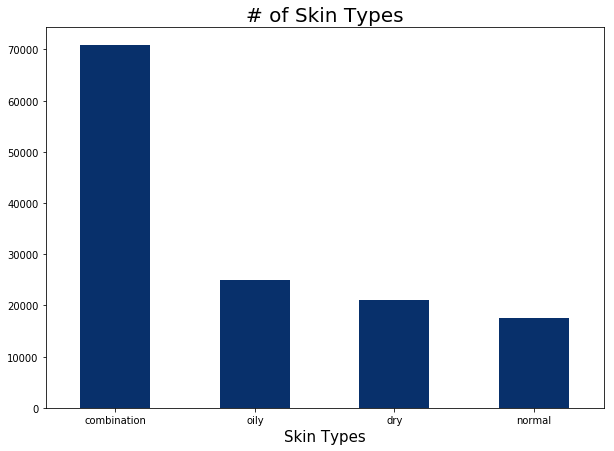

In [172]:
# Number of people with certain skin type
plot_skin(df, 'skin_type', 'review_text')
plt.xlabel('Skin Types', fontsize=15)
plt.title('# of Skin Types', fontsize=20);

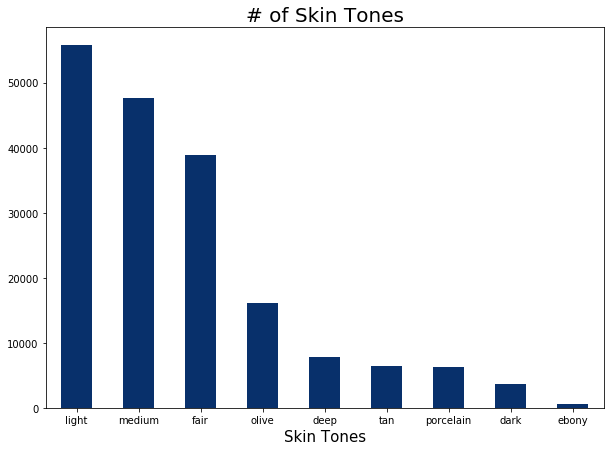

In [173]:
# number of people with different types of skin tones
plot_skin(df, 'skin_tone', 'review_text')
plt.xlabel('Skin Tones', fontsize=15)
plt.title('# of Skin Tones', fontsize=20);

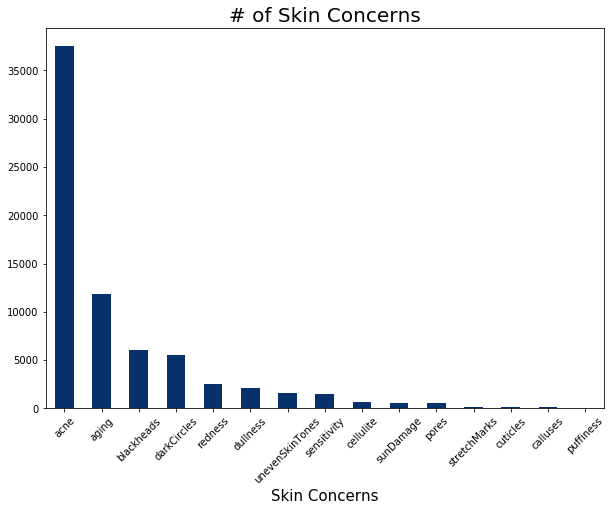

In [175]:
# number of people with different types of skin concerns
plot_skin(df, 'skin_concerns', 'review_text')
plt.xlabel('Skin Concerns', fontsize=15)
plt.xticks(rotation=45)
plt.title('# of Skin Concerns', fontsize=20);

In [15]:
# select the top 3 brands with the most number of reviews
new_df = df[(df['brand'] == "bareMinerals") | 
   (df['brand'] == 'tarte') |
  (df['brand'] == 'Laura Mercier')].copy()

In [16]:
new_df.shape

(72385, 22)

In [17]:
missing_zero_values_table(new_df)

Your selected dataframe has 22 columns and 72385 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_concerns,0,63114,87.2,63114,87.2,object
recommended,1885,61886,85.5,63771,88.1,object
incentivized_review,11812,59993,82.9,71805,99.2,object
skin_type,0,50714,70.1,50714,70.1,object
beauty_insider,0,28814,39.8,28814,39.8,object
location,0,28058,38.8,28058,38.8,object
age,0,27610,38.1,27610,38.1,object
eye_color,0,21678,29.9,21678,29.9,object
skin_tone,0,20308,28.1,20308,28.1,object
user_name,0,1037,1.4,1037,1.4,object


In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72385 entries, 43998 to 274759
Data columns (total 22 columns):
brand                    72385 non-null object
name                     72385 non-null object
brand_id                 72385 non-null int64
brand_image_url          72385 non-null object
product_id               72385 non-null object
product_image_url        72385 non-null object
rating                   72385 non-null int64
skin_type                21671 non-null object
eye_color                50707 non-null object
skin_concerns            9271 non-null object
incentivized_review      12392 non-null object
skin_tone                52077 non-null object
age                      44775 non-null object
beauty_insider           43571 non-null object
user_name                71348 non-null object
review_text              72385 non-null object
price                    72385 non-null object
recommended              10499 non-null object
first_submission_date    72385 non-null obj

In [19]:
new_df['price'].unique()

array(['$29.00', '$24.00 - $45.00', '$39.00', '$30.00', '$45.00',
       '$48.00', '$34.00', '$14.00 - $37.00', '$36.00', '$42.00',
       '$27.00'], dtype=object)

In [20]:
# convert price column from string to float, replace any range prices with mean price
new_df['price'] = new_df['price'].replace({'$24.00 - $45.00': '34.50'})
new_df['price'] = new_df['price'].replace({'$14.00 - $37.00': '30.50'})
new_df['price'] = new_df['price'].apply(lambda x: x.replace('$',''))
new_df['price'] = new_df['price'].astype(float)
# new_df['price'] = pd.to_numeric(df['price'])
# type(new_df['price'].iloc[0])
type(new_df['price'].iloc[0])

numpy.float64

In [21]:
new_df['recommended'].value_counts()

True     8614
False    1885
Name: recommended, dtype: int64

# NLP to create basic model

In [22]:
nlp_df = new_df[['review_text', 'recommended']].copy()
nlp_df.head()

,review_text,recommended
43998,Bare Minerals is great. I just recently starte...,NaN
43999,I can not say anything bad about this. I'm liv...,NaN
44000,I don't get what is so special about this prod...,NaN
44001,First I want to start off by saying that this ...,NaN
44002,I've been using this powder foundation for yea...,NaN


In [23]:
# remove any NAN values
nlp_df.dropna(inplace=True)

In [24]:
# replace T/F values in recommended column with 1 (True) or 0 (False)
nlp_df['recommended'] = np.where((nlp_df['recommended'] == True), 1, 0)

In [25]:
nlp_df.head()

,review_text,recommended
44128,I have been using this product for almost a de...,1
44142,I am a big fan. I am on the fairer side but ha...,1
44176,I love the Bare Minerals Original Foundation p...,1
44218,Lemme first start off by saying I (used to) lo...,0
44221,This was one of my first foundations I ever bo...,0


In [26]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
#     return only_ascii.decode()
    return nfkd_form

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

import string
punctuation_ = set(string.punctuation)

from nltk.corpus import stopwords

stopwords_ = set(stopwords.words('english'))

In [26]:
# use to compare stems before putting into model
def compare_stems(df, col_name):
    porter = PorterStemmer()
    snowball = SnowballStemmer('english')
    wordnet = WordNetLemmatizer()
    
    df[col_name] = [remove_accents(row) for row in df[col_name]]
    df[col_name] = [strip_html_tags(row) for row in df[col_name]]
    df[col_name] = df[col_name].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    df[col_name] = [word_tokenize(row.lower()) for row in df[col_name]]
    df[col_name] = [[word for word in row if not word in stopwords_ and not word in punctuation_]
                   for row in df[col_name]]
    
    docs_porter = df[col_name].apply(lambda row: ' '.join([porter.stem(word) for word in row]))
    docs_snowball = df[col_name].apply(lambda row: ' '.join([snowball.stem(word) for word in row]))
    docs_wordnet = df[col_name].apply(lambda row: ' '.join([wordnet.lemmatize(word) for word in row]))
    
    stem_data = {'porter': docs_porter[:5], 'snowball': docs_snowball[:5], 'lemmatize': docs_wordnet[:5]}
    
    stem_df = pd.DataFrame(stem_data, columns=['porter', 'snowball', 'lemmatize'])
    
    return stem_df

In [27]:
compare_stems(nlp_df, 'review_text')

,porter,snowball,lemmatize
44128,use product almost decad everi time tri someth...,use product almost decad everi time tri someth...,using product almost decade every time try som...
44142,big fan fairer side acn sometim hard get level...,big fan fairer side acn sometim hard get level...,big fan fairer side acne sometimes hard get le...
44176,love bare miner origin foundat powder began us...,love bare miner origin foundat powder began us...,love bare mineral original foundation powder b...
44218,lem first start say use love foundat would swe...,lem first start say use love foundat would swe...,lem first start saying used love foundation wo...
44221,one first foundat ever bought like first make ...,one first foundat ever bought like first make ...,one first foundation ever bought liked first m...


In [27]:
# use to format strings before putting into model after deciding to stem or not
def format_strings(df, col_name, stemming):
    stemmer = stemming
    df[col_name] = [remove_accents(row) for row in df[col_name]]
    df[col_name] = [strip_html_tags(row) for row in df[col_name]]
    df[col_name] = df[col_name].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    df[col_name] = [word_tokenize(row.lower()) for row in df[col_name]]
    df[col_name] = [[word for word in row if not word in stopwords_ and not word in punctuation_]
                   for row in df[col_name]]
    # adjust based on stemming chosen
    df[col_name] = df[col_name].apply(lambda row: ' '.join([stemmer.lemmatize(word) for word in row]))

In [28]:
format_strings(nlp_df, 'review_text', WordNetLemmatizer())

In [29]:
nlp_df.head()

,review_text,recommended
44128,using product almost decade every time try som...,1
44142,big fan fairer side acne sometimes hard get le...,1
44176,love bare mineral original foundation powder b...,1
44218,lem first start saying used love foundation wo...,0
44221,one first foundation ever bought liked first m...,0


In [30]:
def w_freq(text_series):
    countvect = CountVectorizer()
    bag_of_words = countvect.fit_transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in countvect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [194]:
# w_freq(nlp_df['review_text'])

In [32]:
#  vectorizers
tfidf = TfidfVectorizer()
countvect = CountVectorizer()

# models
logistic = LogisticRegression()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

GNB = GaussianNB()
MNB = MultinomialNB()
BNB = BernoulliNB()

In [33]:
y = nlp_df['recommended']

In [34]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df

In [35]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [36]:
def modelling(text_series, y, vectorizer, model):
    # declare X
    X = vectorizer.fit_transform(text_series)
    
    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)
    
    return precision, accuracy, recall, thresh_df, roc_auc, model

In [37]:
# modelling(nlp_df['review_text'], y, TfidfVectorizer(), logistic)

In [38]:
model_list = [logistic, gb, rf, dt, BNB]

In [39]:
# plot multiple rocs for NLP
def plot_multiple_rocs(model_list, text_series, y, vectorizer):
    ax.plot([0,1],[0,1], 'k', label="random")
    for model in model_list:
        results = modelling(text_series, y, vectorizer, model)
        auc_score = results[4]
        plot_roc(ax, results[3], '{} AUC {}'.format(model.__class__.__name__, round(auc_score, 3)))

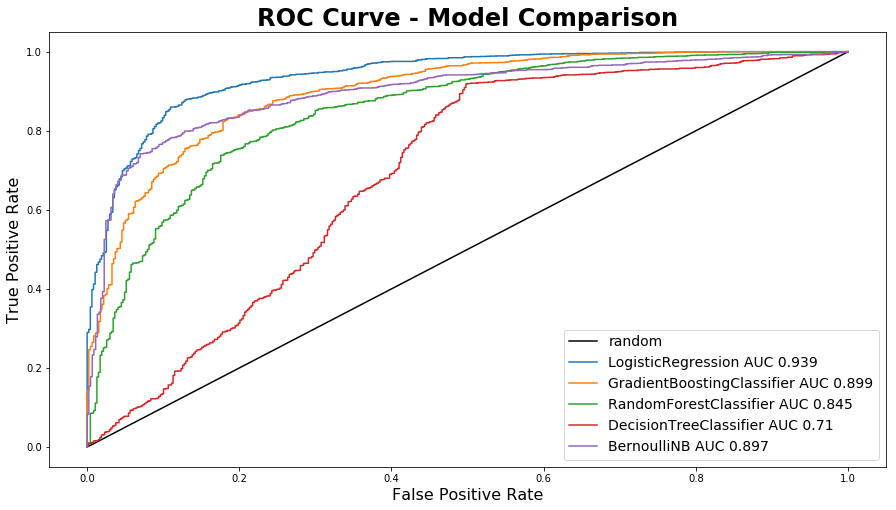

In [40]:
fig, ax = plt.subplots(figsize=(15,8))
plot_multiple_rocs(model_list, nlp_df['review_text'], y, TfidfVectorizer())

In [61]:
# create wordcloud
def create_wordcloud(df, col_name):
    text = ' '.join(review for review in df[col_name])
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')

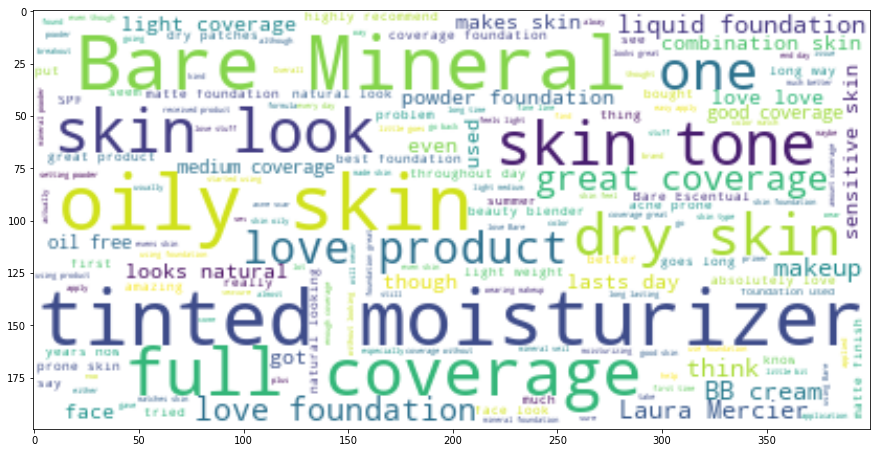

In [62]:
create_wordcloud(new_df, 'review_text')
plt.savefig('imgs/WordCloud1')